<center><strong>中文自然语言处理</strong></center>
<center><strong>Transformer模型(二)</strong></center>
<center><strong>BERT的预训练实践与应用</strong></center>

这是Transformer解读的第二部分, 这部分是实践的部分, 如果你没有看第一部分:   
[汉语自然语言处理-从零解读碾压循环神经网络的transformer模型(一)](https://github.com/aespresso/a_journey_into_math_of_ml/tree/master/03_transformer_tutorial_1st_part) | 视频讲解: [B站讲解](https://www.bilibili.com/video/av58239477/) / [youtube](https://www.youtube.com/watch?v=wLKsaZWeuCM) |    
##### 二. transformer代码解读, 语料数据预处理, BERT的预训练和情感分析的应用:   
首先是今天课程内容的顺序, 我将BERT代码解读放到了最后, 把主要内容排在了前面, 注意我们今天使用的是**PyTorch**深度学习框架, **其实用什么样的框架并不重要**, 本节课**代码的部分不是重点**, 重点是让大家可以掌握$NLP$中**语料预处理**和**建模**并**解决实际应用中出现的困难**的的一些思路, 那话说回来为什么用PyTorch呢?    
我其实用Tensorflow的时间要比PyTorch长很多, 但是目前用了PyTorch之后, 我感觉对于NLP来说, PyTorch真的比Tensorflow好用多了, 因为Tensorflow属于静态图, 建模和调试都很麻烦.    
尤其是序列模型要定义很多variable scope和name scope之类的, 也就是张量的作用域, 这些东西命名搞不好一不小心就会有bug, 而且有些bug不会报错, 当你发现计算结果不对, 要再返回头debug, 而且Tensorflow的静态图不支持调试, 要用sess.run把想要的结果计算出来才可以.   

但是PyTorch是动态图, 就和写numpy一样, 非常方便调试, 而且用class面向对象方式建模, 先声明操作再执行操作, 这样基本不容易在数据流图上出现bug.   
如果你从来没用过**PyTorch**我今天在后面代码部分会带大家大致熟悉一下, 主要是带大家熟悉一下PyTorch的特性, 具体教程官方文档中的快速入门(英文)写的就很好, https://pytorch.org/tutorials/:   
1. 进一步理解$positional \ encoding$, 结合注意力矩阵可视化位置编码;
2. **语言模型**的定义和**BERT解读**;
3. BERT训练之前的准备工作, 语料预处理;
4. BERT的预训练, 训练参数;
5. 使用BERT预训练模型进行自然语言的情感分类;
6. BERT代码解读(这部分因为长度原因放在单独一个视频里).

### 1. 进一步理解$positional \ encoding$, 结合注意力矩阵可视化位置编码;

In [1]:
# 导入依赖库
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot
from IPython.display import Image 
init_notebook_mode(connected=True)

In [0]:
def get_positional_encoding(max_seq_len, embed_dim):
    # 初始化一个positional encoding
    # embed_dim: 字嵌入的维度
    # max_seq_len: 最大的序列长度
    positional_encoding = np.array([
        [pos / np.power(10000, 2 * i / embed_dim) for i in range(embed_dim)]
        if pos != 0 else np.zeros(embed_dim) for pos in range(max_seq_len)])
    positional_encoding[1:, 0::2] = np.sin(positional_encoding[1:, 0::2])  # dim 2i 偶数
    positional_encoding[1:, 1::2] = np.cos(positional_encoding[1:, 1::2])  # dim 2i+1 奇数
    # 归一化, 用位置嵌入的每一行除以它的模长
    # denominator = np.sqrt(np.sum(position_enc**2, axis=1, keepdims=True))
    # position_enc = position_enc / (denominator + 1e-8)
    return positional_encoding

In [0]:
positional_encoding = get_positional_encoding(max_seq_len=100, embed_dim=128)

In [5]:
# 3d可视化
relation_matrix = np.dot(positional_encoding, positional_encoding.T)[1:, 1:]
data = [go.Surface(z=relation_matrix)]
layout = go.Layout(scene={"xaxis": {'title': "sequence length"}, "yaxis": {"title": "sequence length"}})
fig = go.Figure(data=data, layout=layout)
iplot(fig)

上图中, 我们用位置编码矩阵乘以(矩阵乘)他本身的转置, 也就是$PE: \ [seq\_len, \ embedding\_dim ]$, 我们求$PEPE^T$, 得出的维度是$[seq\_len, \ seq\_len ]$. 我们看到上图中, 矩阵的对角线隆起, 也就是值比较大, 是因为一个矩阵乘以他本身的转置之后, 形成的矩阵的对角线正是这个矩阵的每一行$(row)$点乘这一行本身, 所以是值最大的区域(红色部分). 对于位置编码来说, 也就是当前位置与当前位置本身相关程度最高. 再往对角线两边看, 发现以对角线(红色山峰)区域为中心, 两边属于缓慢下降趋势, 这就说明了随着离当前位置越远, 其位置编码的相关程度就越低. 由此可见, 位置编码建立在时间维度的关联关系.

### 2. 语言模型的定义和BERT解读;

什么是语言模型, 其实用一个公式就可以表示$P(c_{1},\ldots ,c_{m})$, 假设我们有一句话, $c_{1}到c_{m}$是这句话里的$m$个字, 而语言模型就是求的是这句话出现的概率是多少.   

比如说在一个语音识别的场景, 机器听到一句话是"wo wang dai san le(我忘带伞了)", 然后机器解析出两个句子, 一个是"我网袋散了", 另一个是"我忘带伞了", 也就是前者的概率大于后者. 然后语言模型就可以判断$P("我忘带伞了") > P("我网袋散了")$, 从而得出这句语音的正确解析结果是"我忘带伞了".

BERT的全称是: Bidirectional Encoder Representations from Transformers, 如果翻译过来也就是**双向transformer编码表达**, 我们在上节课解读了transformer的编码器, 编码器输出的隐藏层就是自然语言序列的数学表达, 那么双向是什么意思呢? 我们来看一下下面这张图.

![](./imgs/bidirectional.png)

上图中$E_i$是指的单个字或词, $T_i$指的是最终计算得出的**隐藏层**, 还记得我们在Transformer(一)中讲到的注意力矩阵和注意力加权, 经过这样的操作之后, 序列里面的每一个字, **都含有这个字前面的信息和后面的信息**, 这就是**双向**的理解, 在这里, 一句话中每一个字, 经过注意力机制和加权之后, **当前这个字等于用这句话中其他所有字重新表达了一遍**, 每个字含有了这句话中所有成分的信息.

#### 在BERT中, 主要是以两种预训练的方式来建立语言模型:
#### BERT语言模型任务一: MASKED LM
在BERT中, Masked LM(Masked language Model)构建了语言模型, 这也是BERT的预训练中任务之一, 简单来说, 就是**随机遮盖或替换**一句话里面任意字或词, 然后让模型通过上下文的理解预测那一个被遮盖或替换的部分, 之后**做$Loss$的时候只计算被遮盖部分的$Loss$**, 其实是一个很容易理解的任务, 实际操作方式如下:   
1. 随机把一句话中$15 \% $的$token$替换成以下内容:   
1) 这些$token$有$80 \% $的几率被替换成$[mask]$;   
2) 有$10 \%$的几率被替换成任意一个其他的$token$;   
3) 有$10 \%$的几率原封不动.
2. 之后让模型**预测和还原**被遮盖掉或替换掉的部分, 模型最终输出的隐藏层的计算结果的维度是:   
$X_{hidden}: [batch\_size, \ seq\_len, \  embedding\_dim]$   
我们初始化一个映射层的权重$W_{vocab}$:   
$W_{vocab}: [embedding\_dim, \ vocab\_size]$   
我们用$W_{vocab}$完成隐藏维度到字向量数量的映射, 只要求$X_{hidden}$和$W_{vocab}$的矩阵乘(点积):   
$X_{hidden}W_{vocab}: [batch\_size, \ seq\_len, \ vocab\_size] $
之后把上面的计算结果在$vocab\_size$(最后一个)维度做$softmax$归一化, 是每个字对应的$vocab\_size$的和为$1$, 我们就可以通过$vocab\_size$里概率最大的字来得到模型的预测结果, 就可以和我们准备好的$Label$做损失($Loss$)并反传梯度了.   
注意做损失的时候, 只计算在第1步里当句中**随机遮盖或替换**的部分, 其余部分不做损失, 对于其他部分, 模型输出什么东西, 我们不在意.

#### BERT语言模型任务二: Next Sentence Prediction
1. 首先我们拿到属于上下文的一对句子, 也就是两个句子, 之后我们要在这两段连续的句子里面加一些特殊$token$:   
$[cls]$上一句话,$[sep]$下一句话.$[sep]$   
也就是在句子开头加一个$[cls]$, 在两句话之中和句末加$[sep]$, 具体地就像下图一样:   

![](./imgs/embeddings.png)

2. 我们看到上图中两句话是$[cls]$ my dog is cute $[sep]$ he likes playing $[sep]$, $[cls]$我的狗很可爱$[sep]$他喜欢玩耍$[sep]$, 除此之外, 我们还要准备同样格式的两句话, 但他们不属于上下文关系的情况;   
$[cls]$我的狗很可爱$[sep]$企鹅不擅长飞行$[sep]$, 可见这属于上下句不属于上下文关系的情况;    
在实际的训练中, 我们让上面两种情况出现的比例为$1:1$, 也就是一半的时间输出的文本属于上下文关系, 一半时间不是.
3. 我们进行完上述步骤之后, 还要随机初始化一个可训练的$segment \ embeddings$, 见上图中, 作用就是用$embeddings$的信息让模型分开上下句, 我们一把给上句全$0$的$token$, 下句啊全$1$的$token$, 让模型得以判断上下句的起止位置, 例如:   
$[cls]$我的狗很可爱$[sep]$企鹅不擅长飞行$[sep]$   
$0 \quad  \  0 \ \ 0 \ \  0 \ \ 0 \ \ 0 \ \ 0 \ \  0 \ \ \ 1 \ \  1 \ \ 1 \ \ 1 \ \ 1 \ \ 1 \ \ 1 \ \ 1 $    
上面$0$和$1$就是$segment \ embeddings$.
4. 还记得我们上节课说过的, 注意力机制就是, 让每句话中的每一个字对应的那一条向量里, 都融入这句话所有字的信息, 那么我们在最终隐藏层的计算结果里, 只要取出$[cls]token$所对应的一条向量, 里面就含有整个句子的信息, 因为我们期望这个句子里面所有信息都会往$[cls]token$所对应的一条向量里汇总:   
模型最终输出的隐藏层的计算结果的维度是:   
我们$X_{hidden}: [batch\_size, \ seq\_len, \  embedding\_dim]$   
我们要取出$[cls]token$所对应的一条向量, $[cls]$对应着$\ seq\_len$维度的第$0$条:   
$cls\_vector = X_{hidden}[:, \ 0, \ :]$   
$cls\_vector \in \mathbb{R}^{batch\_size, \  embedding\_dim}$   
之后我们再初始化一个权重, 完成从$embedding\_dim$维度到$1$的映射, 也就是逻辑回归, 之后用$sigmoid$函数激活, 就得到了而分类问题的推断.   
我们用$\hat{y}$来表示模型的输出的推断, 他的值介于$(0, \ 1)$之间:   
$\hat{y} = sigmoid(Linear(cls\_vector)) \quad \hat{y} \in (0, \ 1)$

至此$BERT$的训练方法就讲完了, 是不是很简单, 下面我们来为$BERT$的预训练准备数据.

### 3. BERT训练之前的准备工作, 语料预处理;
__字典的制作, 参见目录./corpus/BERT_preprocessing.ipynb文件中的讲解__   

### 4. BERT的预训练, 训练参数;
BERT论文中, 推荐的模型参数为: 基准模型$transformer\_block=12, \ embedding\_dimension=768, \ num\_heads=12, \ Total Param eters=110M)$, 可见其中共有$1.1$亿参数, 除此之外, 还有比基准模型还大的高性能模型, 参数量为$3$亿, 要想训练并使用这么大参数的模型, 需要充裕的计算资源!    

但是经过我的实际测试, 结合我目前正在研究的命名实体识别, 语义分析, 关系抽取和知识图谱的需求, 发现其实这个参数比较过剩, 我们今天训练BERT所用的参数为$transformer\_block=6, \ embedding\_dimension=384, \ num\_heads=12, \ Total Param eters=23M)$, 可见我把参数缩减到$2$千万, 但即使这样, 使用一块11GB显存的2080Ti显卡, 训练维基百科语料的BERT也需要一周的时间.   

注意我们今天所使用的模型, 是在开源项目 https://github.com/huggingface/pytorch-transformers 的基础上修改而来, 其中我添加了很多中文注释, 添加了预处理模块, 添加了动态padding优化了速度(在后面代码解读的部分会讲到), 添加了情感分析模块等;    
中文维基百科语料: https://github.com/brightmart/nlp_chinese_corpus 我只是做了一下预处理, 以适应BERT的预训练, 预处理之后的语料可以在readme.md文件中的百度网盘地址下载;   

我已经把使用维基百科语料预训练好的BERT模型上传到了百度网盘, 请在readme.md文件中查看, 我还想提醒大家一下, 网盘上的BERT预训练模型在训练的时候, 使用了一些简单的技巧, 但这些技巧并没有出现在这个教程开源的代码里面, 这是因为某些不方便的原因, 不过我可以告诉大家这些技巧, 大家可以自己实现一下, 另外, 不建议大家用我公开的BERT训练代码来重新训练BERT模型, 因为我上传的已经训练好的BERT性能要更好一些:
##### BERT训练技巧:   
1) 因为我们是按单个字为单位训练BERT, 所以在Masked LM里面, 把句子中的英文单词分出来, 将英文单词所在的区域一起遮盖掉, 让模型预测这个部分;    
2) 很多句子里含有数字, 显然在Masked LM中, 让模型准确地预测数据是不现实的, 所以我们把原文中的数字(包括整数和小数)都替换成一个特殊token, #NUM#, 这样模型只要预测出这个地方应该是某些数字就可以来.
##### BERT训练代码解读在第6部分


### 5. 使用BERT预训练模型进行自然语言的情感分类;
1) **情感分析语料预处理**: 参见目录./corpus/sentiment_preprocessing.ipynb, 我用使用来酒店评论语料, 不过这个语料规模要比2018年用LSTM做情感分析的要大一些, 正面评论和负面评论各5000条, 其实这也是玩具级数据集, 用BERT参数这么大的模型, 训练会产生严重过拟合, 泛化能力差的情况, 这也是我们下面需要解决的问题;   
2) 回顾在BERT的训练中Next Sentence Prediction中, 我们取出$[cls]$对应的那一条向量, 然后把他映射成1个数值并用$sigmoid$函数激活:   
$$\hat{y} = sigmoid(Linear(cls\_vector)) \quad \hat{y} \in (0, \ 1)$$
3) **动态学习率和提前终止$(early \ stop)$**:   
上一步我们将语料划分成了训练和测试集, 我们的训练方式是, 每个$epoch$, 用训练集训练. 对模型性能的衡量标准是$AUC$, $AUC$的衡量标准对二分类非常易用, 这里因为时间关系就不讲了, 如果大家不熟悉可以上网搜寻相关资料.    
当前$epoch$训练完毕之后, 用测试集衡量当前训练结果, 并记下当前$epoch$的$AUC$, 如果当前的$AUC$较上一个$epoch$没有提升, 那就**降低学习率**, 实际操作是让当前的学习率降低$1/5$, 直到$10$个$epoch$测试集的$AUC$都没有提升, 就终止训练.   
我们的初始学习率是$1e-6$, 因为我们是在维基百科预训练语料的基础上进行训练的, 属于下游任务, 只需要微调预训练模型就好.   
4) **解决过拟合问题:**   
但在实际操作中, 使用$\hat{y} = sigmoid(Linear(cls\_vector)) \quad \hat{y} \in (0, \ 1)$的方式, 发现虽然在训练集和测试集上$AUC$都很高, 但实际随便输入一些从各种网上随便找的一些酒店评论后, 发现泛化能力不好. 这是因为我们的训练数据集非常小, 即使区分训练集和测试集, 但因为整体数据形态比较单一, 模型遇到自己没见过的情况就很容易无法做出正确判断, 为了提高模型的泛化性能, 我尝试了另一种模型结构:   
![](./imgs/mean_max_pool.jpg)

如上图, 我尝试$mean \ max \ pool$的一种把隐藏层的序列转换为一条向量的方式, 其实就是沿着$sequence \ length$的维度分别求均值和$max$, 之后拼起来成为一条向量, 之后同样映射成一个值再激活, 伪代码如下:   
$X_{hidden}: [batch\_size, \ seq\_len, \  embedding\_dim]$   
$mean\_pooled = mean(X_{hidden}, \ dimension=seq\_len)  \quad [batch\_size, \  embedding\_dim]$
$max\_pooled = max(X_{hidden}, \ dimension=seq\_len)  \quad [batch\_size, \  embedding\_dim]$
$mean\_max\_pooled = concatenate(mean\_pooled, \ max\_pooled, \ dimension=embedding\_dim ) \quad [batch\_size, \  embedding\_dim * 2]$   
上式中$mean\_max\_pooled$也就是我们得到的一句话的数学表达, 含有这句话的信息, 其实这也是一种$DOC2VEC$的方法, 也就是把一句话转换成一条向量, 而且无论这句话有多长, 转换出来向量的维度都是一样的, 之后可以用这些向量做一些分类聚类等任务.   
下一步我们同样做映射, 之后用$sigmoid$激活:   
$\hat{y} = sigmoid(Linear(mean\_max\_pooled)) \quad \hat{y} \in (0, \ 1)$   
怎样理解这样的操作呢, 隐藏层就是一句话的数学表达, 我们求均值和最大值正数学表达对这句话的平均响应, 和最大响应, 之后我们用线性映射来识别这些响应, 从而得到模型的推断结果.  

我们还用了$weight  \ decay$的方式, 其实就是$L2 \ normalization$, 在PyTorch里有接口可以直接调用, 一会会说到, 其实$L2$正则的作用就是防止参数的值变得过大或过小, 我们可以设想一下, 由于我们的训练数据很少, 所以实际使用模型进行推断的时候有些字和词或者句子结构的组合模型都是没见过的, 模型里面参数的值很大的话会造成遇到某一些特别的句子或者词语的时候, 模型对句子的响应过大, 导致最终输出的值偏离实际, 其实我们希望模型更从容淡定一些, 所以我们加入$L2 \ normalization$.   

除此之外, 我们预训练的BERT有6个transformer block, 我们在情感分析的时候, 只用了3个, 因为后面实在是参数太多, 容易导致过拟合, 所以在第三个transformer block之后, 就截出隐藏层进行$pooling$了, 后面的transformer block都没有用到.   

再除此之外, 我使用了$dropout$机制, $dropout$设为了$0.4$, 因为模型参数是在是太多, 所以在训练的时候直接让$40\%$的参数失能, 防止过拟合.   

经过以上方法, 模型训练集和测试机的$AUC$都达到了$0.95$以上, 而且经过实际的测试, 模型也可以基本比较正确的分辨出语句的情感极性.   

5) **阈值微调:**   
经过模型的推断, 输出的值介于0到1之间, 我们可以认为只要这个值在0.5以上, 就是正样本, 如果在0.5以下, 就是副样本, 其实这是不一定的, 0.5通常不是最佳的分类边界, 所以我写了一个用来寻找最佳阈值的脚本, 在./metrics/\_\_init\_\_.py里面.   
这个脚本的方法是从0.01到0.99定义99个阈值, 高于阈值算正样本, 低于算副样本, 然后与测试集计算$f1 \ score$, 之后选出可以使$f1 \ score$最高的阈值, 在训练中, 每一个$epoch$都会运行一次寻找阈值的脚本.   

In [0]:
import pandas as pd
df = pd.read_pickle("./sentiment_state_dict_mean_max_pool/df_log.pickle")
# 训练日志的尾部, 可见训练集train_auc和测试集test_auc都到达了0.95以上,
# 实际上测试集的auc比训练集还要高, 因为训练集有dropout
df.tail()

,epoch,train_loss,train_auc,test_loss,test_auc
414,414,0.274383,0.954070,0.283045,0.958663
415,415,0.280170,0.952098,0.283048,0.958663
416,416,0.279494,0.952490,0.283052,0.958663
417,417,0.277347,0.953116,0.283056,0.958663
418,418,0.278657,0.952766,0.283057,0.958663


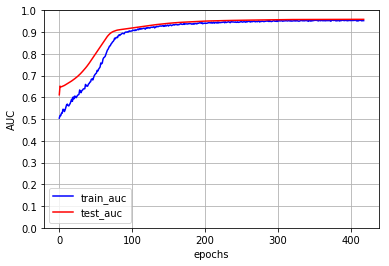

In [0]:
# 让我们来画一下图
import matplotlib.pyplot as plt
plt.plot(df["train_auc"].tolist(), c="b", label="train_auc")
plt.plot(df["test_auc"].tolist(), c="r", label="test_auc")
plt.xlabel("epochs")
plt.ylabel("AUC")
plt.yticks([i/10 for i in range(11)])
plt.grid()
plt.legend()
plt.show()

6) **情感分析代码解读和实际测试**:   
代码解读见视频讲解, 下面我们进行测试:

In [0]:
from Sentiment_Inference import *

In [0]:
model = Sentiment_Analysis(max_seq_len=300, batch_size=2)

./sentiment_state_dict_mean_max_pool/sentiment.model.epoch.418 loaded!


In [0]:
# https://www.booking.com/reviews.zh-cn.html
test_list = [
    "有几次回到酒店房间都没有被整理。两个人入住，只放了一套洗漱用品。",
    "早餐时间询问要咖啡或茶，本来是好事，但每张桌子上没有放“怡口糖”（代糖），又显得没那么周到。房间里卫生间用品补充，有时有点漫不经心个人觉得酒店房间禁烟比较好",
    '十六浦酒店有提供港澳码头的SHUTTLE BUS, 但氹仔没有订了普通房, 可能是会员的关系 UPGRADE到了DELUXE房,风景是绿色的河, 感观一般, 但房间还是不错的, 只是装修有点旧了另外品尝了酒店的自助晚餐, 种类不算多, 味道OK, 酒类也免费任饮, 这个不错最后就是在酒店的娱乐场赢了所有费用, 一切都值得了!',
    '地理位置优越，出门就是步行街，也应该是耶路撒冷的中心地带，去老城走约20分钟。房间很实用，虽然不含早餐，但是楼下周边有很多小超市和餐厅、面包店，所以一切都不是问题。',
    '实在失望！如果果晚唔系送朋友去码头翻香港一定会落酒店大堂投诉佢！太离谱了！我地吃个晚饭消费千几蚊 ，买单个黑色衫叫Annie果个唔知系部长定系经理录左我万几蚊！简直系离晒大谱的 ！咁样的管理层咁大间酒店真的都不敢恭维！',
    '酒店服务太棒了, 服务态度非常好, 房间很干净',
    "服务各方面没有不周到而的地方, 各方面没有没想到的细节",
    "房间设施比较旧，虽然是古典风格，但浴室的浴霸比较不好用。很不满意的是大厅坐下得消费，不人性化，而且糕点和沙拉很难吃，贵而且是用塑料盒子装的，5星级？特别是青团，58块钱4个，感觉放了好几天了，超级难吃。。。把外国朋友吓坏了。。。",
    "南京东路地铁出来就能看到，很方便。酒店大堂和房间布置都有五星级的水准。",
    "服务不及5星，前台非常不专业，入住时会告知你没房要等，不然就加钱升级房间。前台个个冰块脸，对待客人好像仇人一般，带着2岁的小孩前台竟然还要收早餐费。门口穿白衣的大爷是木头人，不会提供任何帮助。入住期间想要多一副牙刷给孩子用，竟然被问为什么。五星设施，一星服务，不会再入住！"
]
model(test_list)

有几次回到酒店房间都没有被整理。两个人入住，只放了一套洗漱用品。
负样本, 输出值0.19
----------
早餐时间询问要咖啡或茶，本来是好事，但每张桌子上没有放“怡口糖”（代糖），又显得没那么周到。房间里卫生间用品补充，有时有点漫不经心个人觉得酒店房间禁烟比较好
正样本, 输出值0.56
----------
十六浦酒店有提供港澳码头的SHUTTLE BUS, 但氹仔没有订了普通房, 可能是会员的关系 UPGRADE到了DELUXE房,风景是绿色的河, 感观一般, 但房间还是不错的, 只是装修有点旧了另外品尝了酒店的自助晚餐, 种类不算多, 味道OK, 酒类也免费任饮, 这个不错最后就是在酒店的娱乐场赢了所有费用, 一切都值得了!
正样本, 输出值0.99
----------
地理位置优越，出门就是步行街，也应该是耶路撒冷的中心地带，去老城走约20分钟。房间很实用，虽然不含早餐，但是楼下周边有很多小超市和餐厅、面包店，所以一切都不是问题。
正样本, 输出值0.96
----------
实在失望！如果果晚唔系送朋友去码头翻香港一定会落酒店大堂投诉佢！太离谱了！我地吃个晚饭消费千几蚊 ，买单个黑色衫叫Annie果个唔知系部长定系经理录左我万几蚊！简直系离晒大谱的 ！咁样的管理层咁大间酒店真的都不敢恭维！
负样本, 输出值0.05
----------
酒店服务太棒了, 服务态度非常好, 房间很干净
正样本, 输出值0.88
----------
服务各方面没有不周到而的地方, 各方面没有没想到的细节
负样本, 输出值0.03
----------
房间设施比较旧，虽然是古典风格，但浴室的浴霸比较不好用。很不满意的是大厅坐下得消费，不人性化，而且糕点和沙拉很难吃，贵而且是用塑料盒子装的，5星级？特别是青团，58块钱4个，感觉放了好几天了，超级难吃。。。把外国朋友吓坏了。。。
负样本, 输出值0.18
----------
南京东路地铁出来就能看到，很方便。酒店大堂和房间布置都有五星级的水准。
正样本, 输出值0.98
----------
服务不及5星，前台非常不专业，入住时会告知你没房要等，不然就加钱升级房间。前台个个冰块脸，对待客人好像仇人一般，带着2岁的小孩前台竟然还要收早餐费。门口穿白衣的大爷是木头人，不会提供任何帮助。入住期间想要多一副牙刷给孩子用，

In [0]:
text = "对于这个亲子房来说，没有浴缸对于比较小的小朋友来说可能会有点不太方便，小的时候不太会站立洗澡的，所以可能需要洗盆浴，我们宝宝4岁了，其实也没有关系，但是之前有自己经历过带6个月宝宝出去玩的，很多店家觉得浴缸浪费空间所以都只有淋浴房。但是自己给宝宝洗澡的时候就非常尴尬…不知道这家是不是可以有租用的。因为我们不是一定需要，也没有做询问。"
model(text)

对于这个亲子房来说，没有浴缸对于比较小的小朋友来说可能会有点不太方便，小的时候不太会站立洗澡的，所以可能需要洗盆浴，我们宝宝4岁了，其实也没有关系，但是之前有自己经历过带6个月宝宝出去玩的，很多店家觉得浴缸浪费空间所以都只有淋浴房。但是自己给宝宝洗澡的时候就非常尴尬…不知道这家是不是可以有租用的。因为我们不是一定需要，也没有做询问。
负样本, 输出值0.31
----------
